In [2]:
%matplotlib inline

# Copyright 2019 Alexander Judge
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import csv
import os
from functools import partial

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import QuantileTransformer, PolynomialFeatures, OneHotEncoder, KBinsDiscretizer
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import mutual_info_regression
from scipy.stats import ks_2samp

import utils


np.random.seed()
rc('text', usetex=True)
rc("font", family="serif")

In [3]:
# Combine data grids in a single data set with a common mask.
# Amalgamate low-count lithologies into a single category.
# Ignore the warning: it's an internal scipy issue.

DATA_DIR = 'data'
GRID_RES = 0.1
GRID_INFO = [
    ('benthic_biomass_mega', 'Wei_benthic_biomass_mega.nc'),
    ('bottom_water_current', 'botvelStdev.nc'),
    ('bottom_water_oxygen', 'oxygen_bottomwater_seiteretal_2005.nc'),
    ('seabed_lithology', 'seabed_lithology_v1.nc'),
    ('sedimentation_rate', 'average_sedimentation_rate_from_decomp_sed_thick_cm_per_ka.nc'),
    ('summer_surface_productivity', 'SeaWiFS_summer_productivity_12year_stack.nc'),
    ('total_organic_carbon', 'TOC_Seiteretal2004.nc'),
    ('water_depth', 'etopo_0.1deg.nc')
]
LOW_COUNT_LITHS = [1., 2., 3., 8., 10., 11.]
LITH_INFO = {
    4.: (1, 'Clay'),
    5.: (2, 'Calcareous ooze'),
    6.: (3, 'Radiolarian ooze'),
    7.: (4, 'Diatom ooze'),
    9.: (5, 'Mixed calcareous/siliceous ooze'),
    12.: (6, 'Siliceous mud'),
    13.: (7, 'Fine-grained calcareous sediment'),
    14.: (8, 'Other')
}


x, y = np.arange(-180, 180, GRID_RES), np.arange(-90, 90, GRID_RES)
x = xr.DataArray(data=x, coords=[('longitude', x)], attrs={'units': 'degrees_east'}, name='longitude')
y = xr.DataArray(data=y, coords=[('latitude', y)], attrs={'units': 'degrees_north'}, name='latitude')
x_grid, y_grid = np.meshgrid(x.values, y.values)
xy = np.vstack([x_grid.ravel(), y_grid.ravel()]).T
is_valid = np.ones((y.size, x.size)).astype(bool)
data_vars = {}
for v, f in GRID_INFO:
    ds = xr.open_dataset(os.path.join(DATA_DIR, f))
    z_grid = utils.interp_ds(ds, xy)[0].reshape((y.size, x.size))
    not_nan = ~np.isnan(z_grid)
    # Convert bathymetry to water depth.
    if v == 'water_depth':
        z_grid = -z_grid
        is_valid[not_nan] &= z_grid[not_nan] > 0
    # Scale bottom water current units to cm / s.
    elif v == 'bottom_water_current':
        z_grid *= 1e2
    # Reassign lithology codes.
    elif v == 'seabed_lithology':
        for l in LOW_COUNT_LITHS:
            np.place(z_grid, z_grid == l, [14])
        for l, info in LITH_INFO.items():
            np.place(z_grid, z_grid == l, [info[0]])
    is_valid &= not_nan
    data_vars[v] = xr.DataArray(
        data=z_grid, coords={'longitude': x, 'latitude': y}, dims=['latitude', 'longitude'], name=v
    )
for v in data_vars.keys():
    data_vars[v].values[~is_valid] = np.nan
ds = xr.Dataset(data_vars=data_vars, coords={'longitude': x, 'latitude': y})
ds.to_netcdf('grids.nc')

/Users/alex/miniconda3/envs/pipe-43/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:2514: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.values[idx_res]


In [7]:
# Load exploration data and interpolate grids at locations.

NODULE_FILE = 'nodules_lonlat.csv'
CONTROL_FILE = 'control_lonlat.csv'


data_nodules = pd.read_csv(os.path.join(DATA_DIR, NODULE_FILE))
data_nodules['nodules'] = 1
data_control = pd.read_csv(os.path.join(DATA_DIR, CONTROL_FILE))
data_control['nodules'] = 0
data_exp = pd.concat(
    [data_nodules[['longitude', 'latitude', 'nodules']], data_control[['longitude', 'latitude', 'nodules']]],
    sort=False
)
values, var_names = utils.interp_ds(ds, data_exp[['longitude', 'latitude']].values)
data_exp = data_exp\
    .assign(**{v: values[:, i] for i, v in enumerate(var_names)})\
    .dropna(subset=var_names)\
    .reset_index(drop=True)
data_nodules = pd.merge(data_exp, data_nodules, how='inner', on=['latitude', 'longitude', 'nodules'])
data_control = pd.merge(data_exp, data_control, how='inner', on=['latitude', 'longitude', 'nodules'])
data_nodules.drop('nodules', axis=1).to_csv('nodules.csv', index=False)
data_control.drop('nodules', axis=1).to_csv('control.csv', index=False)

In [4]:
# Generate Fibonnacci lattice and interpolate grids at lattice locations.
# Ignore the warning: it's an internal scipy issue.

LATTICE_SIZE = 200001 # Note that roughly half the points will be discarded as non-oceanic.


data_lat = pd.DataFrame(utils.fib_lattice(LATTICE_SIZE), columns=['longitude', 'latitude'])
values, var_names = utils.interp_ds(ds, data_lat[['longitude', 'latitude']].values)
data_lat = data_lat\
    .assign(**{v: values[:, i] for i, v in enumerate(var_names)})\
    .dropna().reset_index(drop=True)
data_lat.to_csv('lattice.csv', index=False)

In [5]:
# Calculate KS statistics.

var_cols = [info[0] for info in GRID_INFO]
cont_cols = [c for c in var_cols if c != 'seabed_lithology']
ks_stats = pd.DataFrame(columns=['ks_stat', 'p_value'], index=cont_cols)
for i, c in enumerate(cont_cols):
    ks_stats.loc[c] = ks_2samp(data_exp[c].values, data_lat[c].values)
ks_stats.to_csv('ks_stats.csv')
ks_stats

,ks_stat,p_value
benthic_biomass_mega,0.0525441,1.39511e-23
bottom_water_current,0.0478603,1.22731e-19
bottom_water_oxygen,0.152685,5.86827e-196
sedimentation_rate,0.126132,7.31454e-134
summer_surface_productivity,0.0936099,6.37394e-74
total_organic_carbon,0.164717,5.47681e-228
water_depth,0.130539,2.38938e-143


In [6]:
# Transform data and fit model.

POLY_DEGREE = 2


qt = QuantileTransformer().fit(data_lat[cont_cols].values)
pt = PolynomialFeatures(degree=POLY_DEGREE, include_bias=False).fit(data_lat[cont_cols].values)
ohe = OneHotEncoder(categories='auto', sparse=False).fit(data_lat[['seabed_lithology']].values)

def transformer(data):
    X_cont = pt.transform(qt.transform(data[cont_cols].values))
    X_lith = ohe.transform(data[['seabed_lithology']].values)
    X_int = []
    for i in range(X_cont.shape[1]):
        for j in range(X_lith.shape[1]):
            X_int.append(X_cont[:, i] * X_lith[:, j])
    X_int = np.vstack(X_int).T
    X = np.concatenate([X_cont, X_lith, X_int], axis=1)
    return X

X = transformer(data_exp[var_cols])
y = data_exp['nodules'].values
model = utils.EBLogisticRegression(max_iter=200, tol=1e-2, solver_max_iter=10000).fit(X, y)

In [7]:
# Calculate nodule probability mean, upper and lower bounds on the lattice.

BOUND = 0.05

X = transformer(data_lat[var_cols])
p_mean = model.prob(X)
p_lwr = model.prob(X, bound=BOUND)
p_upr = model.prob(X, bound=1 - BOUND)

In [8]:
# Sample nodule probabilities over the lattice from the model.
# Calculate mutual information between variables and nodule probability.

N_SAMPS = 100
N_NEIGHBORS = 10


p_samps = model.prob_rvs(transformer(data_lat[var_cols]), N_SAMPS)
mi_samps = np.apply_along_axis(
    partial(mutual_info_regression, data_lat[var_cols], n_neighbors=N_NEIGHBORS),
    0,
    p_samps
)
mi_samps = pd.DataFrame(mi_samps, index=var_cols)
mi_samps.to_csv('mi_samps.csv')
mi = pd.DataFrame(
    {'mean': mi_samps.mean(axis=1), 'std': mi_samps.std(axis=1)},
    index=var_cols
).sort_values(by='mean', ascending=False)
mi = mi / mi.max().max()
mi.to_csv('mi.csv')

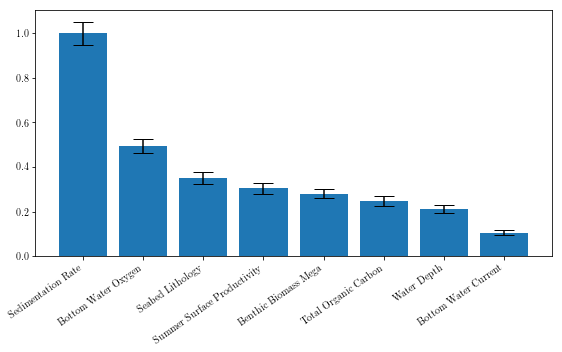

In [9]:
# Plot mutual information scores.
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 5))
ax.bar(x=np.arange(mi.shape[0]), height=mi['mean'], yerr=mi['std'], capsize=10)
ax.set_xticklabels([None] + [l.replace('_', ' ').title() for l in mi.index.values], fontsize=10, ha="right")                                                                           
ax.tick_params(axis="x", labelrotation=35.)
fig.tight_layout()
fig.savefig('mi.pdf')

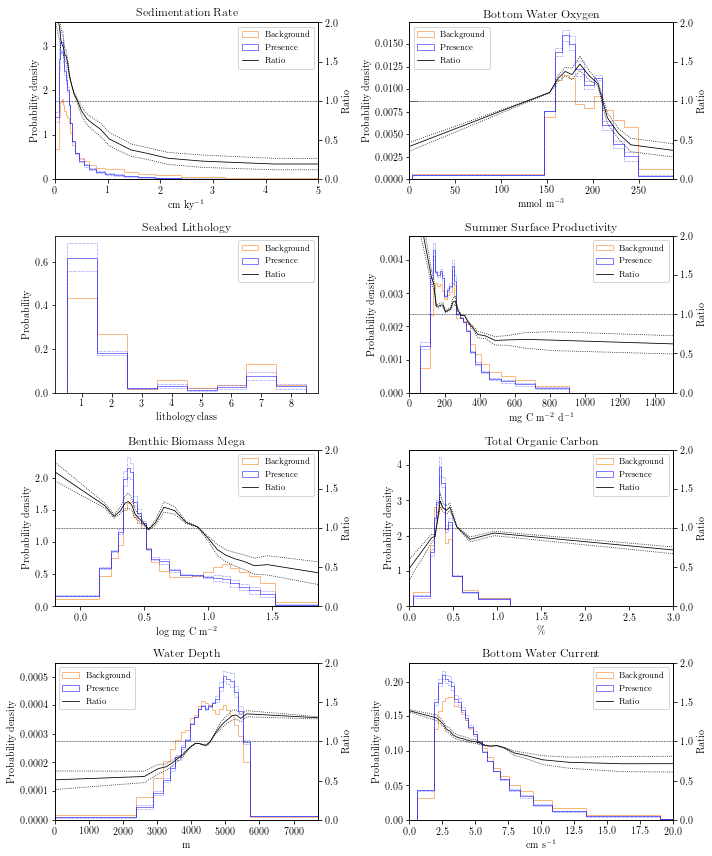

In [11]:
# Generate variable dependence plots.

N_BINS_SMALL = 12
N_BINS_LARGE = 24
VAR_BOUNDS = {
    'benthic_biomass_mega': (-0.2, 2.5),
    'bottom_water_current': (0, 20),
    'bottom_water_oxygen': (0, 326),
    'seabed_lithology': (0.1, 8.9),
    'sedimentation_rate': (0, 5),
    'summer_surface_productivity': (0, 1500),
    'total_organic_carbon': (0, 3),
    'water_depth': (0, 8000)
}
VAR_UNITS = {
    'benthic_biomass_mega': '$\log$ mg C m$^{-2}$',
    'bottom_water_current': 'cm s$^{-1}$',
    'bottom_water_oxygen': 'mmol m$^{-3}$',
    'seabed_lithology': 'lithology class',
    'sedimentation_rate': 'cm ky$^{-1}$',
    'summer_surface_productivity': 'mg C m$^{-2}$ d$^{-1}$',
    'total_organic_carbon': '$\%$',
    'water_depth': 'm'
}
LEGEND_LOCS = {
    'benthic_biomass_mega': 1,
    'bottom_water_current': 1,
    'bottom_water_oxygen': 2,
    'seabed_lithology': 1,
    'sedimentation_rate': 1,
    'summer_surface_productivity': 1,
    'total_organic_carbon': 1,
    'water_depth': 2
}


fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 12))
axes = axes.ravel()
weights = [
    {'name': 'bkg', 'label': 'Background', 'color': 'xkcd:orange', 'ls': '-', 'w': np.ones(data_lat.shape[0])},
    {'name': 'mean', 'label': 'Presence', 'color': 'b', 'ls': '-', 'w': p_mean / p_mean.mean()},
    {'name': 'lwr', 'label': None, 'color': 'b', 'ls': ':', 'w': p_lwr / p_lwr.mean()},
    {'name': 'upr', 'label': None, 'color': 'b', 'ls': ':', 'w': p_upr / p_upr.mean()}
]
for i, v in enumerate(mi.index.values):
    ax1 = axes[i]
    if v == 'seabed_lithology':
        bins=[x[0] for x in LITH_INFO.values()] + [9]
        ylabel = 'Probability'
        align = 'left'
    else:
        if v in ['total_organic_carbon', 'bottom_water_oxygen']:
            n_bins = N_BINS_SMALL
        else:
            n_bins = N_BINS_LARGE
        bins = KBinsDiscretizer(n_bins=n_bins).fit(data_lat[[v]].values).bin_edges_[0]
        ylabel = 'Probability density'
        align = 'mid'
    x = data_lat[v].values   
    bin_heights = {}
    for w in weights:
        n, *_ = ax1.hist(
            x, bins=bins, range=VAR_BOUNDS[v], density=True, histtype='step', align=align, linewidth=0.5,
            weights=w['w'], label=w['label'], linestyle=w['ls'], color=w['color']
        )
        bin_heights[w['name']] = n
    if v != 'seabed_lithology':
        ax2 = ax1.twinx()
        x = ((bins + np.roll(bins, shift=1)) / 2)[1:]
        x0 = np.array([3 * x[0] - 2 * x[1]])
        x = np.concatenate((x0, x))
        ratios = {}
        ratios['mean'] = bin_heights['mean'] / bin_heights['bkg']
        r = np.vstack((bin_heights['lwr'] / bin_heights['bkg'], bin_heights['upr'] / bin_heights['bkg']))
        ratios['lwr'] = r.min(axis=0)
        ratios['upr'] = r.max(axis=0)
        for k in ratios.keys():
            r0 = np.array([3 * ratios[k][0] - 2 * ratios[k][1]])
            ratios[k] = np.concatenate((r0, ratios[k]))
        for w in weights[1:]:
            if w['name'] == 'mean':
                label = 'Ratio'
            else:
                label = None
            ax2.plot(x, ratios[w['name']], color='k', linewidth=0.8, linestyle=w['ls'], label=label)
        ax2.set_ylabel('Ratio')
#         xlim = [bins[:2].mean(), min(bins[-2:].mean(), VAR_BOUNDS[v][1])]
        xlim = [VAR_BOUNDS[v][0], min(bins[-2:].mean(), VAR_BOUNDS[v][1])]
    else:
        xlim = VAR_BOUNDS[v]
        ax1.xaxis.set_major_locator(plt.MultipleLocator(1))
    ax2.plot(xlim, np.ones(2), color='k', linewidth=0.5, linestyle='--')
    ax2.set_ylim([0, 2])
    ax1.set_xlim(xlim)
    ax1.set_xlabel(VAR_UNITS[v])
    ax1.set_ylabel(ylabel)
    ax1.set_title(v.replace('_', ' ').title())
    handles, labels = [], []
    for ax in [ax1, ax2]:
        h, l = ax.get_legend_handles_labels()
        handles.extend(h)
        labels.extend(l)
    ax1.legend(handles, labels, fontsize='small', loc=LEGEND_LOCS[v])
fig.tight_layout()
fig.savefig('variable_dependence.pdf')

In [25]:
# Evaluate model probabilities and ROR on high-res lat-lon grid.

BATCH_SIZE = 10000


x, y = np.arange(-180, 180, GRID_RES), np.arange(-90, 90, GRID_RES)
x = xr.DataArray(data=x, coords=[('longitude', x)], attrs={'units': 'degrees_east'}, name='longitude')
y = xr.DataArray(data=y, coords=[('latitude', y)], attrs={'units': 'degrees_north'}, name='latitude')
x_grid, y_grid = np.meshgrid(x.values, y.values)
xy = np.vstack([x_grid.ravel(), y_grid.ravel()]).T
grid_data = pd.DataFrame(xy, columns=['longitude', 'latitude'])
for v in var_cols:
    grid_data[v] = ds.data_vars[v].values.ravel()
n_batches = grid_data.dropna().shape[0] // BATCH_SIZE
p = []
for i in range(n_batches):
    idx0 = i * BATCH_SIZE
    if i == n_batches - 1:
        idx1 = grid_data.dropna().shape[0]
    else:
        idx1 = (i + 1) * BATCH_SIZE
    X_batch = transformer(grid_data.dropna()[var_cols].iloc[idx0:idx1])
    p_batch = np.concatenate(
        [
            model.prob(X_batch)[:, np.newaxis],
            model.prob(X_batch, bound=BOUND)[:, np.newaxis],
            model.prob(X_batch, bound=1 - BOUND)[:, np.newaxis]
        ],
        axis=1
    )
    p.append(p_batch)
p = np.concatenate(p, axis=0)
y_grid_rad = y_grid * np.pi / 180
delta_angle = GRID_RES * np.pi / 180
solid_angle = delta_angle * (np.sin(y_grid_rad + delta_angle) - np.sin(y_grid_rad))
data_vars = {}
idx_valid = grid_data.dropna().index
for i, name in enumerate(['op_mean', 'op_lwr', 'op_upr']):
    grid_data[name] = np.nan
    grid_data.loc[idx_valid, name] = p[:, i]
    data_vars[name] = xr.DataArray(
        data=grid_data[name].values.reshape((y.size, x.size)), coords={'longitude': x, 'latitude': y},
        dims=['latitude', 'longitude'], name=name
    )
ror_grid = grid_data['op_mean'].values.reshape((y.size, x.size)) * solid_angle
ror_grid = ror_grid / ror_grid.mean()
data_vars['ror'] = xr.DataArray(
    data=ror_grid, coords={'longitude': x, 'latitude': y}, dims=['latitude', 'longitude'], name='ror'
)
ds = xr.Dataset(data_vars=data_vars, coords={'longitude': x, 'latitude': y})
ds.to_netcdf('probability_grids.nc')